In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamf import *

import time

np.random.seed(12345)

# Define variable names

In [2]:
species = ["s"+str(i+1) for i in range(6)]
species

['s1', 's2', 's3', 's4', 's5', 's6']

# Import sequenced data

In [3]:
full_data = pd.read_csv("gLV_data/Simulated_gLV_data_full.csv")
full_data

,Treatments,Time,s1,s2,s3,s4,s5,s6
0,exp_1,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
1,exp_1,24.0,0.079099,0.323530,0.081160,0.362944,0.047798,0.001000
2,exp_1,48.0,0.048447,0.186921,0.093324,0.272168,0.101055,0.035251
3,exp_2,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
4,exp_2,24.0,0.121137,0.123034,0.067271,0.278213,0.072206,0.001000
...,...,...,...,...,...,...,...,...
184,mono_exp_62,24.0,0.001000,0.001000,0.001000,0.056762,0.061516,0.001000
185,mono_exp_62,48.0,0.001000,0.001000,0.004617,0.054432,0.017020,0.001000
186,mono_exp_63,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000
187,mono_exp_63,24.0,0.030410,0.013468,0.001000,0.002725,0.001000,0.246181


# Define function to make predictions on test data

In [4]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)

        # save predictions after initial value 
        for i, (true, pred, std) in enumerate(zip(output_true[1:], output[1:], stdv[1:])):
            y_true += list(true)
            y_pred += list(pred)
            y_std  += list(std)
            test_times += [tspan[i+1]]*numspecies
            all_species_names += list(species)
            test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+5)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)   

            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {species[i]}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return test_treatments, test_times, all_species_names, y_true, y_pred, y_std

# Initialize model parameters

In [5]:
# system dimensions
ns = len(species)
nu = 0

# map to hidden dimension
stdv = 1./np.sqrt(ns*ns)
A = np.random.uniform(0, -stdv, [ns, ns])
a = np.random.uniform(0, stdv, ns)

# concatenate parameters 
params = np.concatenate((A.flatten(), a))
prior  = np.zeros_like(params)

n_params = len(params)
n_params

42

# Define model

In [6]:
# using NODE model 
def system(t, s, params, ctrl_params): 
    
    # map to hidden dimension
    A = jnp.reshape(params[:ns**2], [ns,ns])
    a = params[ns**2:]

    # rate of change of species 
    dsdt = s * (A@s + a)

    return dsdt

# Define compression functions

In [7]:
# define compression functions 
# compressor0 = lambda x: jnp.expand_dims(jnp.sum(x), 0)     # sum over outputs 
compressor1 = lambda x: x

compressors = [compressor1]

## Define ODE (time, x, parameters, u(t), control parameters)

In [8]:
# instantiate gLV fit 
model = ODE(system = system, 
            dataframes=[full_data],
            compressors = compressors,
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [species],
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-4)
print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating precision...
Total samples: 126, Updated regularization: 3.48e-01
Total weighted fitting error: 202.072
Total weighted fitting error: 114.030
Total weighted fitting error: 74.581
Total weighted fitting error: 58.199
Total weighted fitting error: 40.009
Total weighted fitting error: 37.213
Total weighted fitting error: 32.751
Total weighted fitting error: 28.043
Total weighted fitting error: 27.872
Total weighted fitting error: 27.545
Total weighted fitting error: 26.943
Total weighted fitting error: 26.003
Total weighted fitting error: 24.948
Total weighted fitting error: 24.845
Total weighted fitting error: 24.659
Total weighted fitting error: 24.367
Total weighted fitting error: 24.365
     fun: 24.36490198075587
     jac: array([-2.5473425e+00,  2.5122190e-01, -1.1082077e-01, -2.0781386e+00,
       -4.1280496e-01, -1.7356166e+00, -1.8884572e-01, -4.3389767e-01,
       -2.0799637e-03, -7.0530629e-01, -5.9806633e-01,  5.9304759e-03,
        2.4863131e-02, -1.8178195e-02,  7.1

Total samples: 126, Updated regularization: 2.71e-02
Total weighted fitting error: 374.025
Total weighted fitting error: 373.867
Total weighted fitting error: 373.668
Total weighted fitting error: 373.458
Total weighted fitting error: 373.454
     fun: 373.45394020209335
     jac: array([-5.4652481e+00,  2.9527817e+00, -1.6978188e+00,  5.7364960e+00,
        1.0369015e+00, -1.0471213e+01,  3.8761270e-01,  1.4204113e+00,
        7.4839020e-01,  1.6880696e+00, -2.8637600e-01, -9.5775604e-02,
       -6.2360764e-02,  2.8261480e+00,  5.0485897e-01,  5.6893539e-01,
        1.3598531e+00,  1.6896415e+00, -1.3689041e-02,  1.0197735e+00,
       -3.1071138e-01,  9.5244086e-01, -1.9830179e-01,  4.4046450e-01,
        6.7853355e-01,  7.5659037e+00,  1.4467078e+00,  4.3177567e+00,
       -4.8758626e-02, -1.4514121e+00, -2.2733122e-01, -8.0885541e-01,
        5.3695798e-01, -1.8635087e+00, -6.2418771e-01,  1.1352434e+00,
       -2.8124451e+01,  4.7683859e+00,  1.0575333e+01,  3.1789351e-01,
        

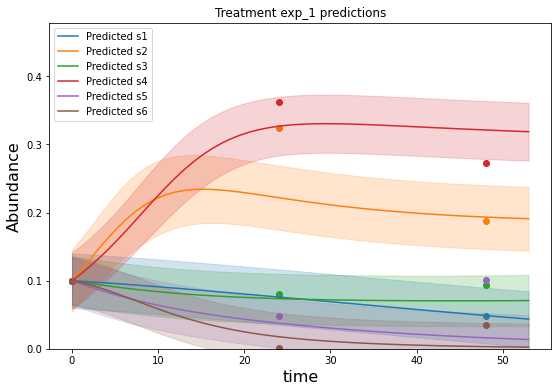

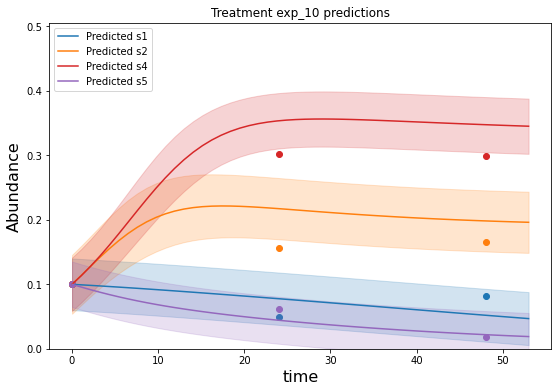

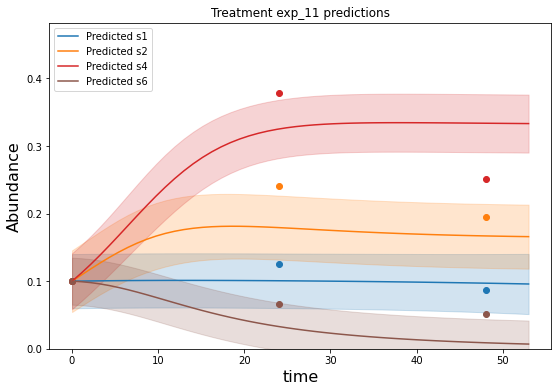

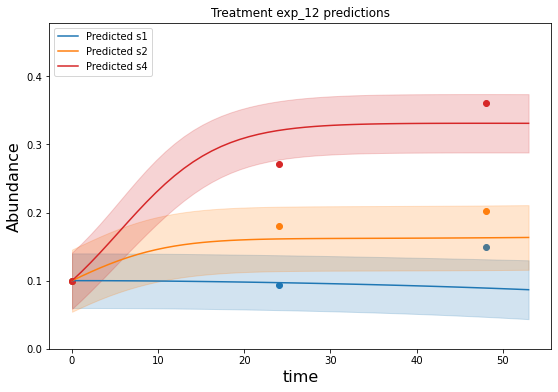

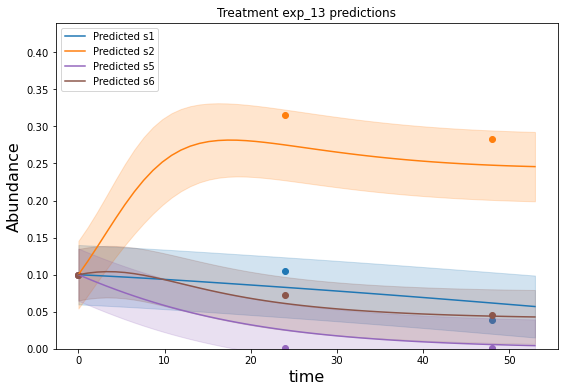

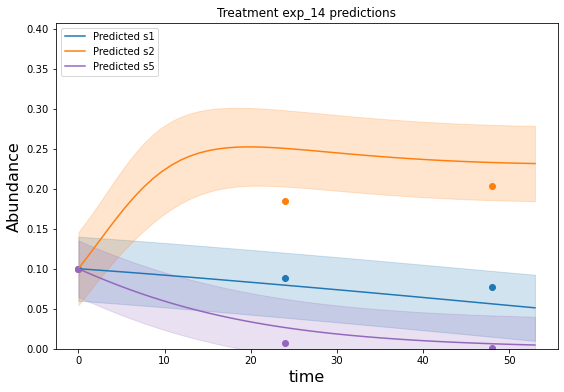

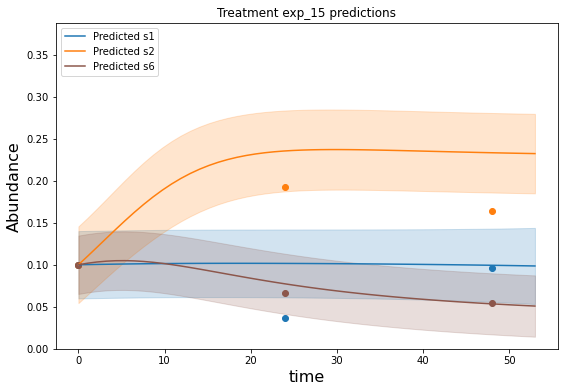

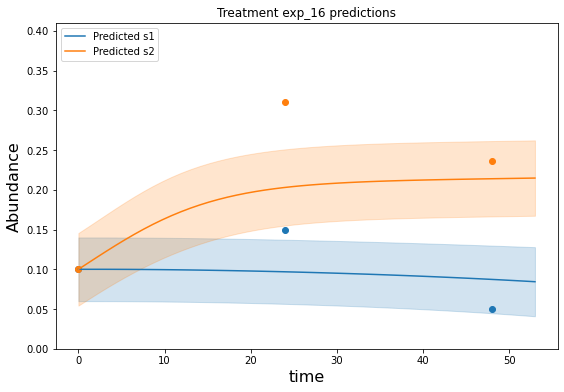

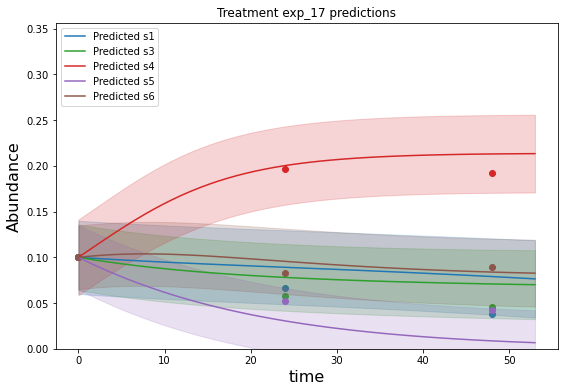

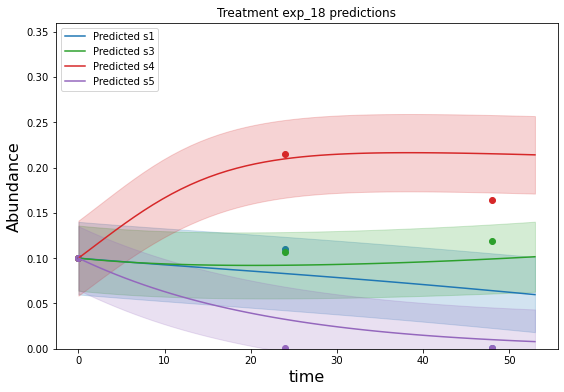

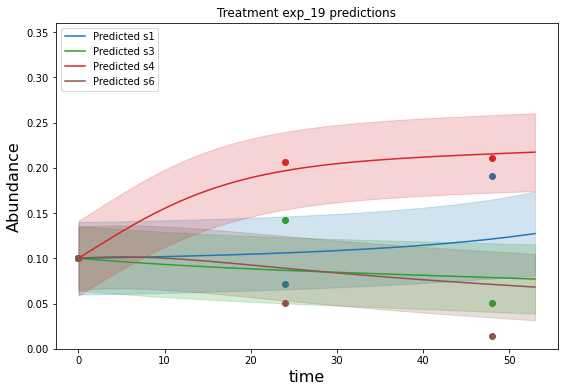

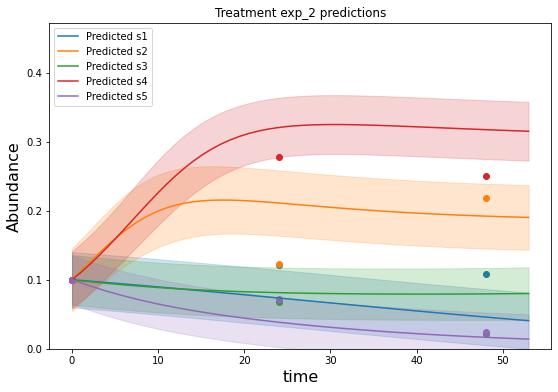

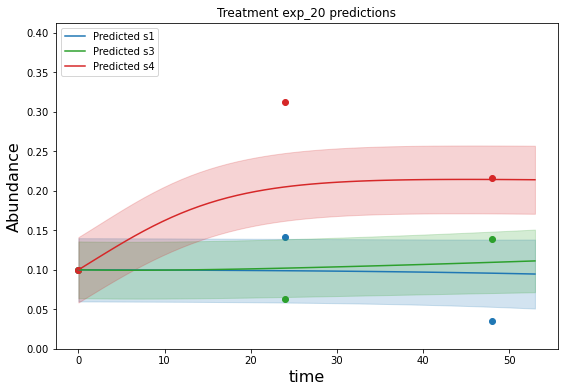

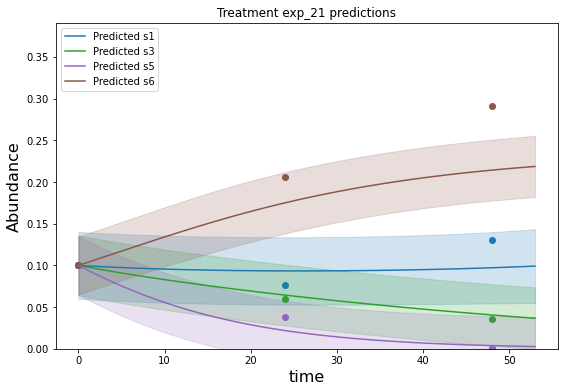

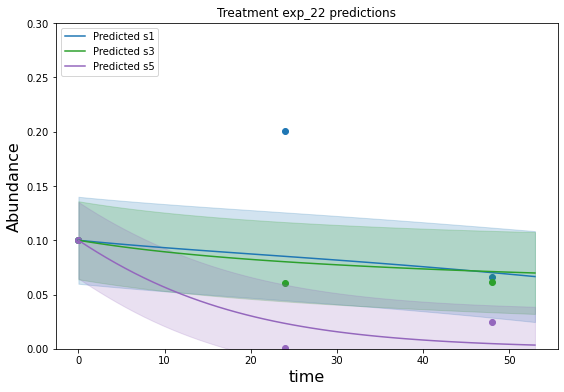

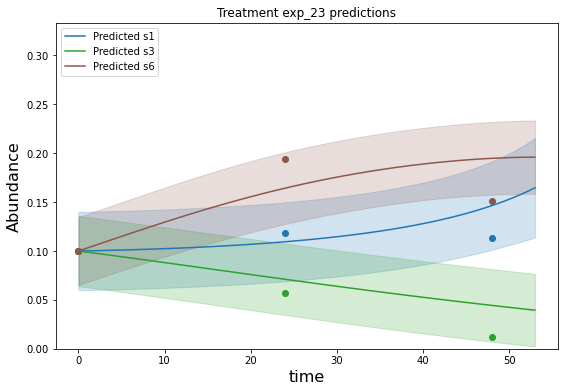

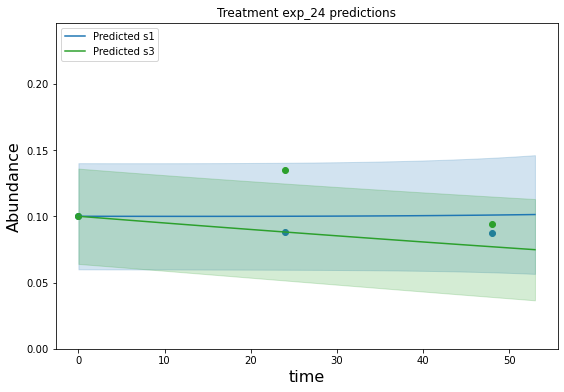

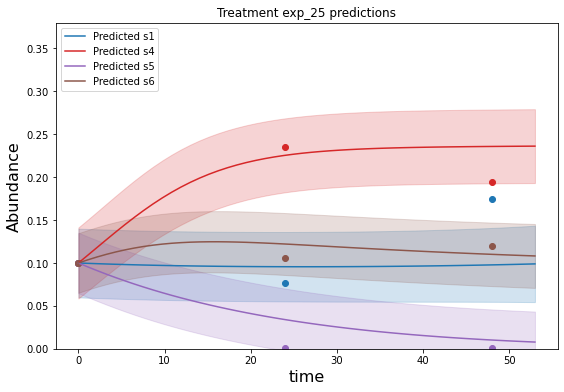

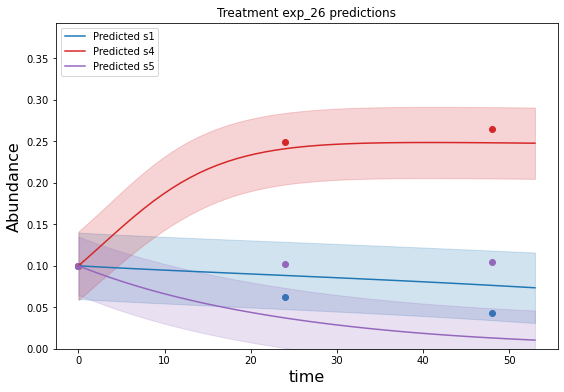

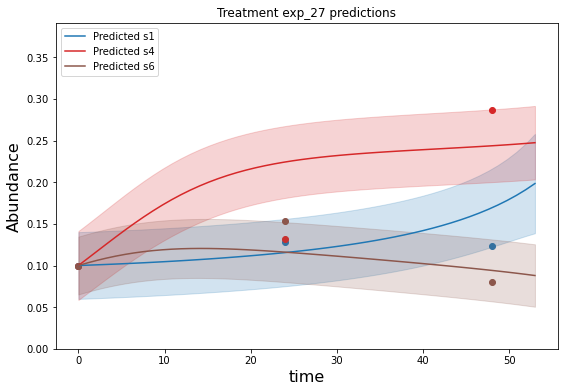

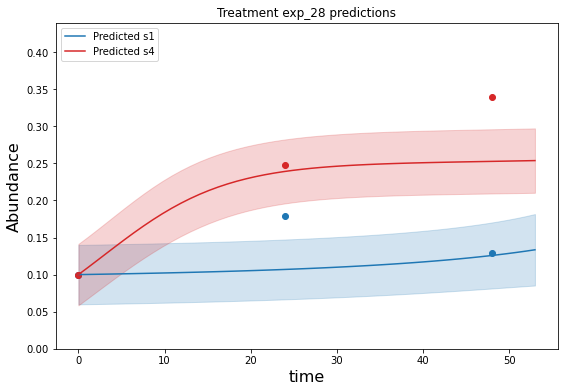

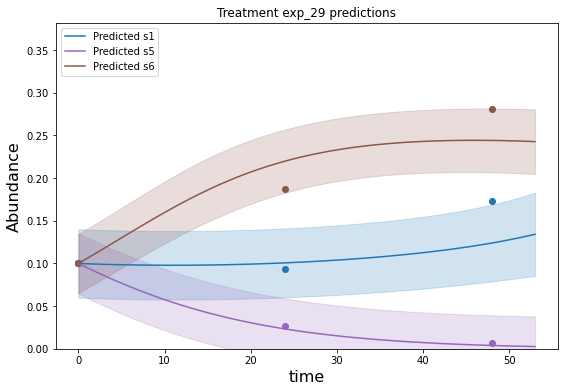

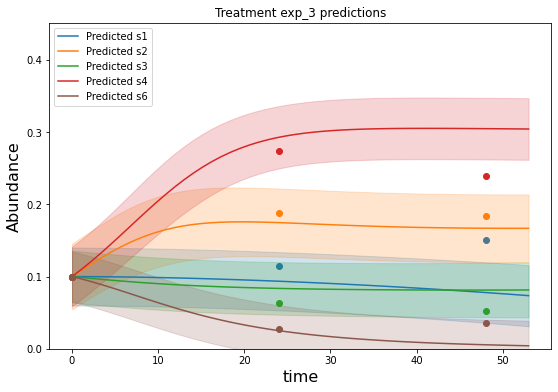

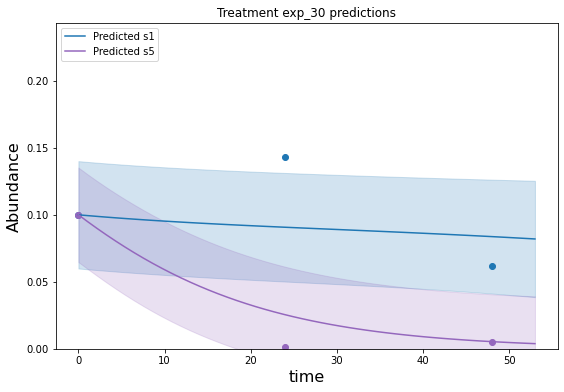

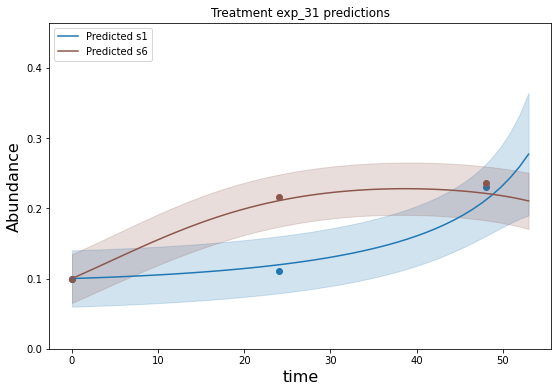

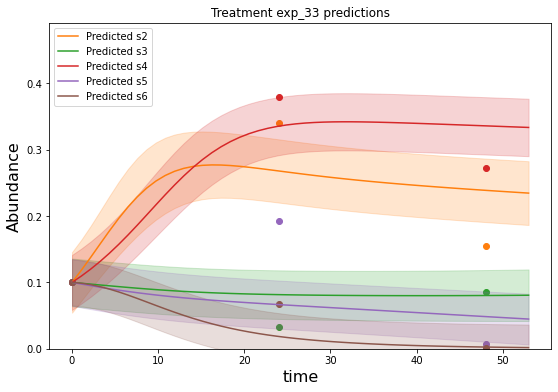

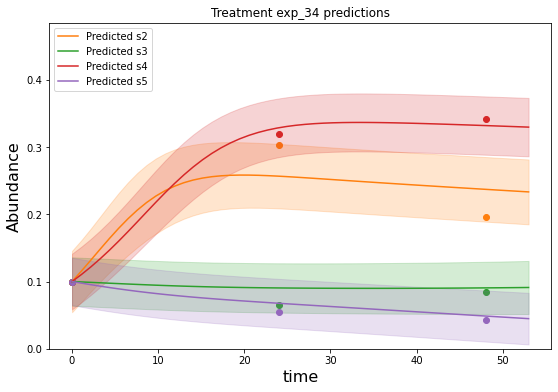

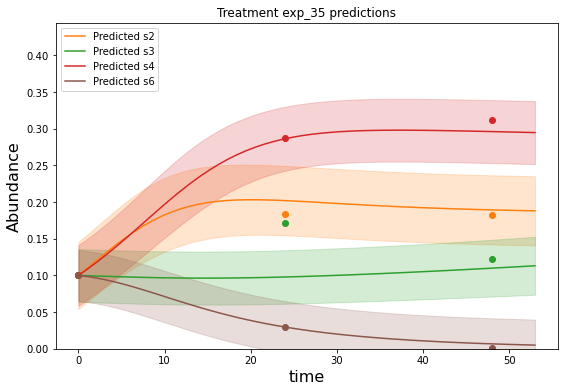

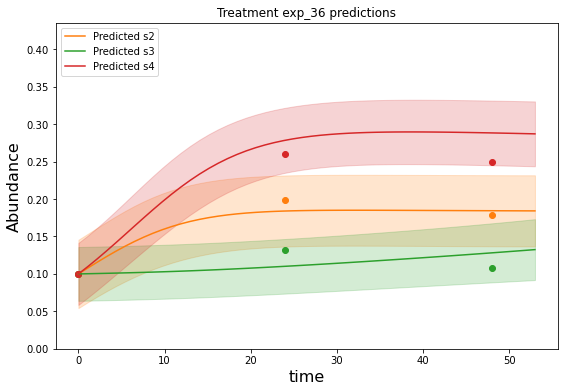

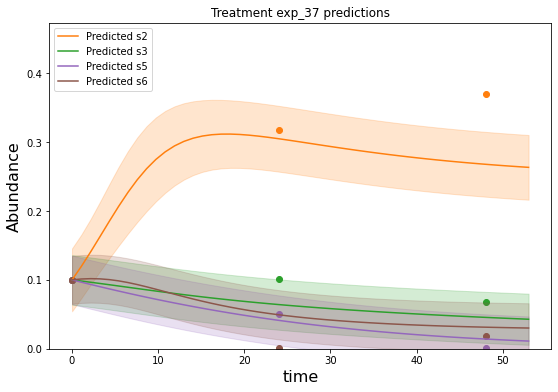

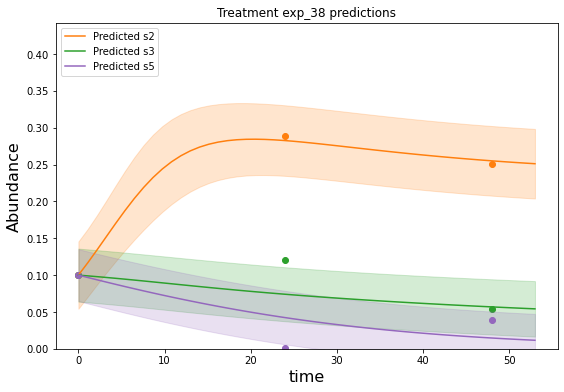

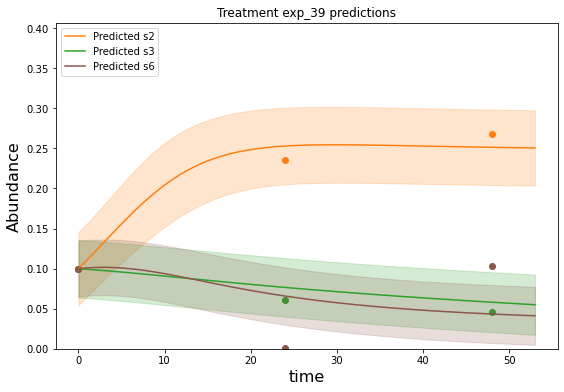

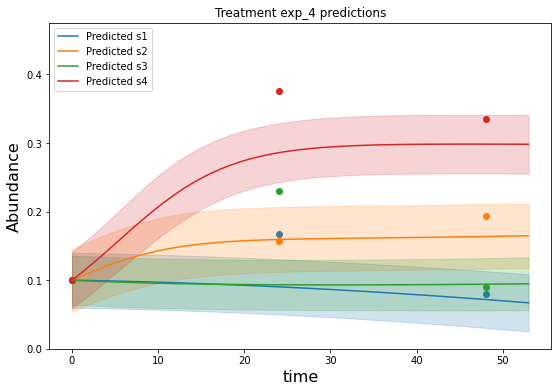

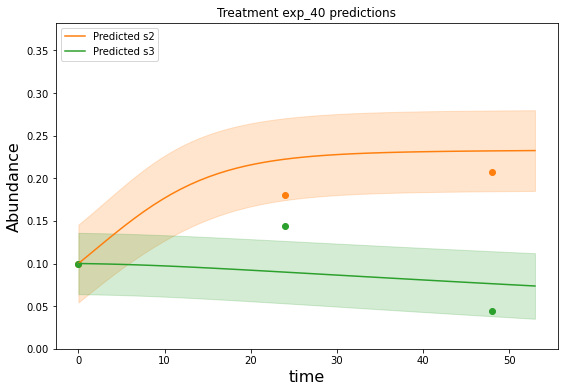

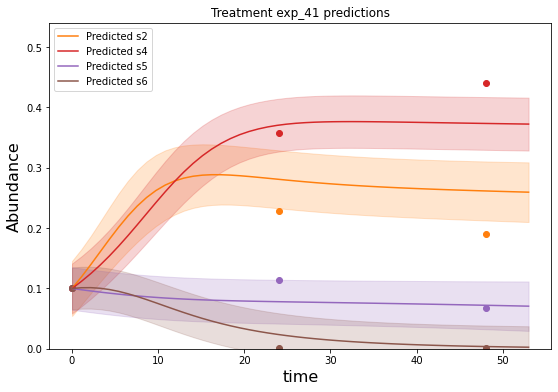

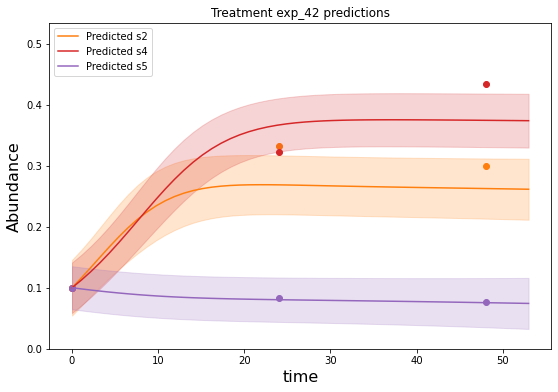

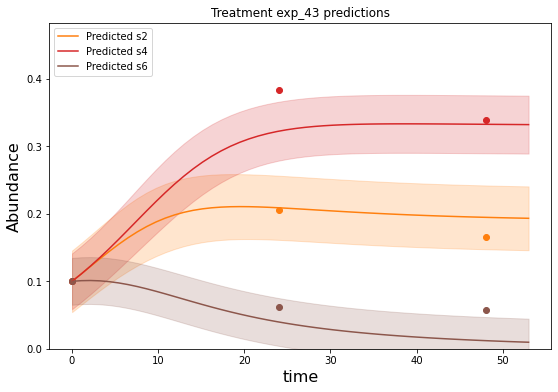

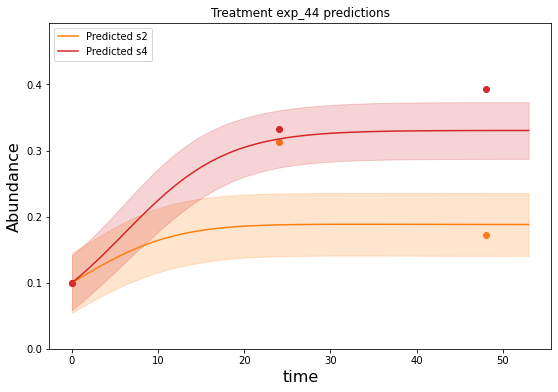

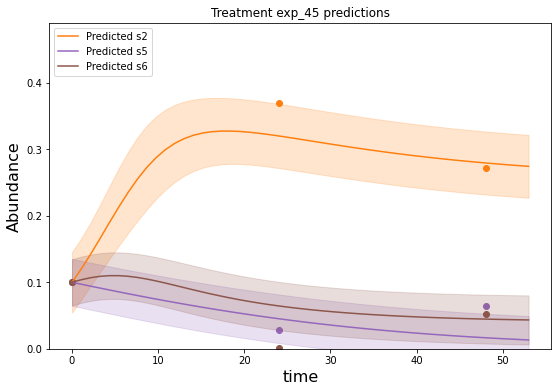

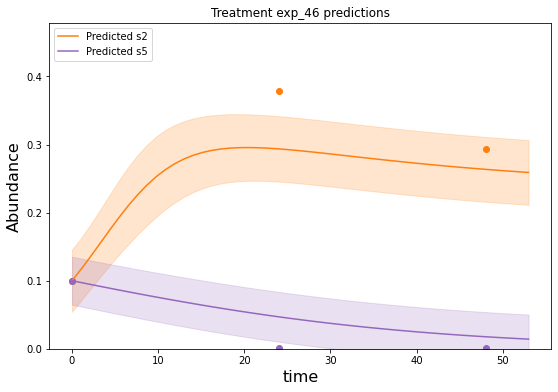

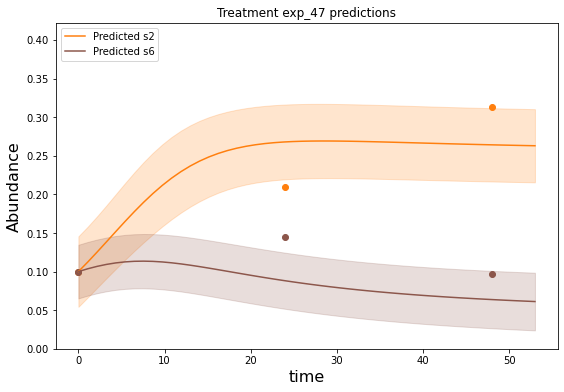

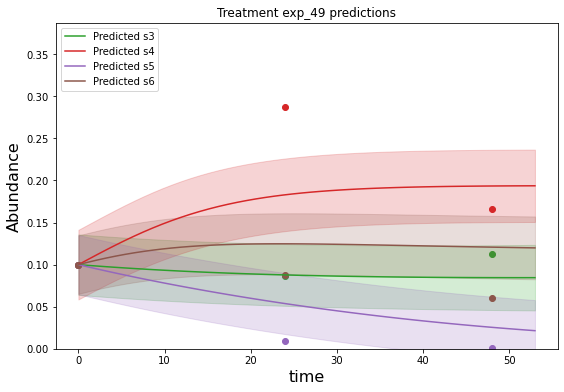

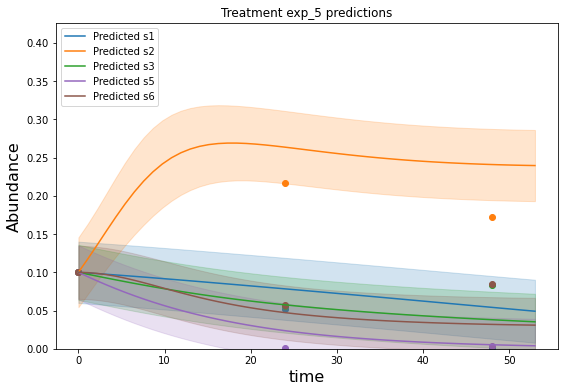

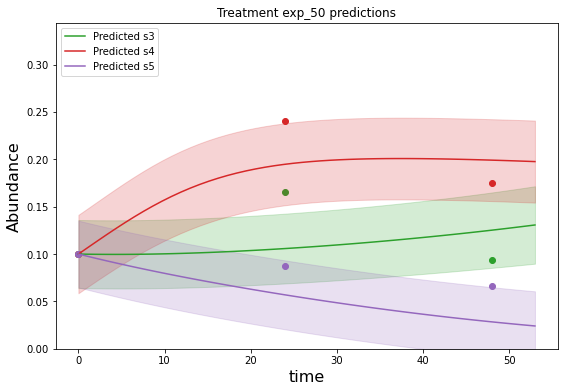

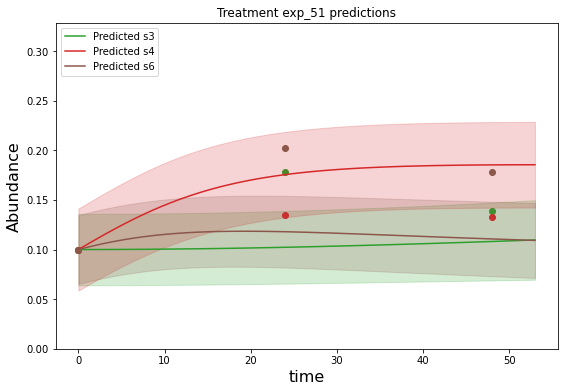

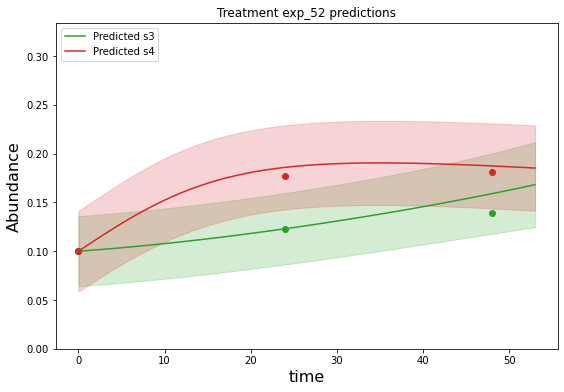

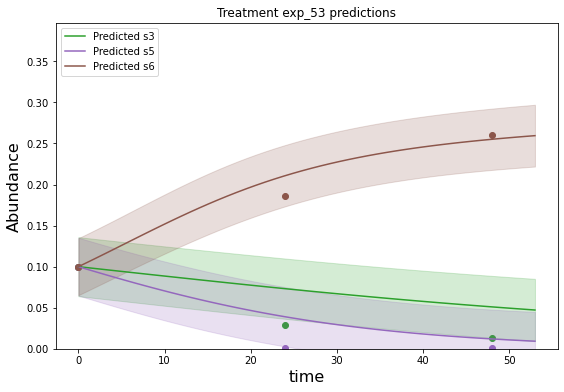

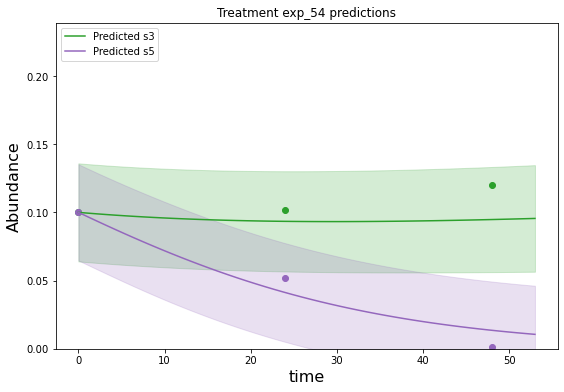

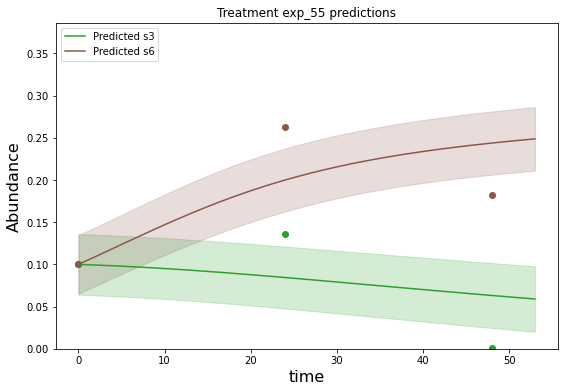

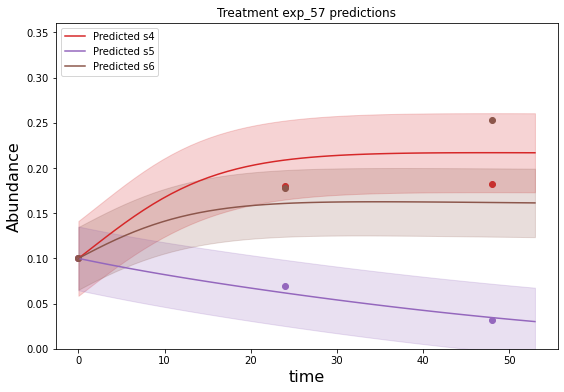

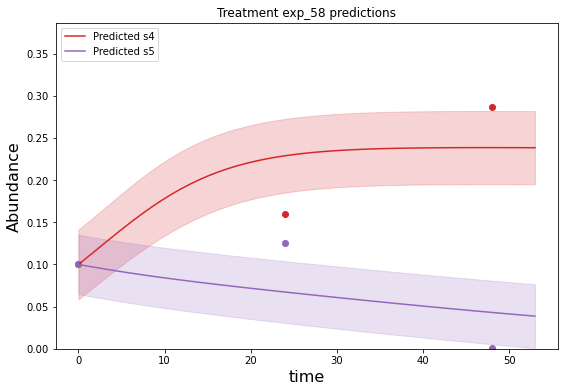

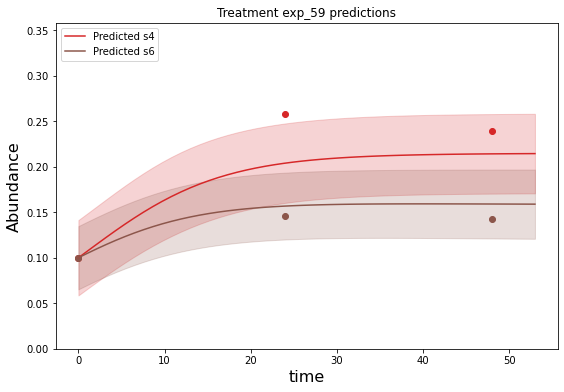

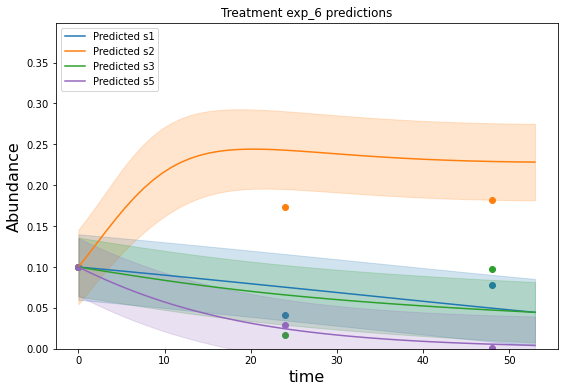

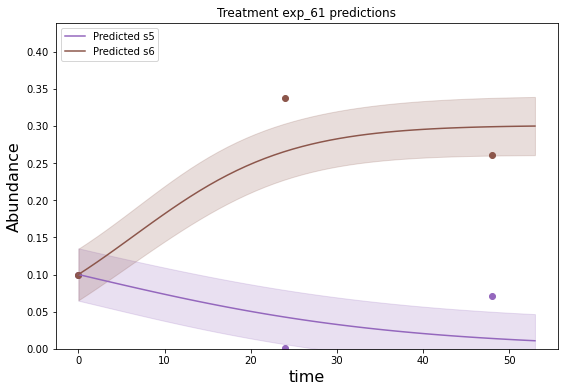

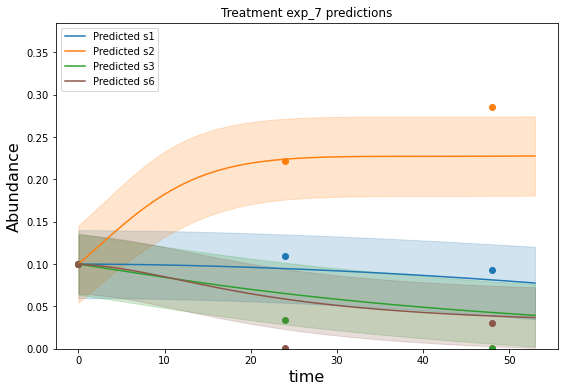

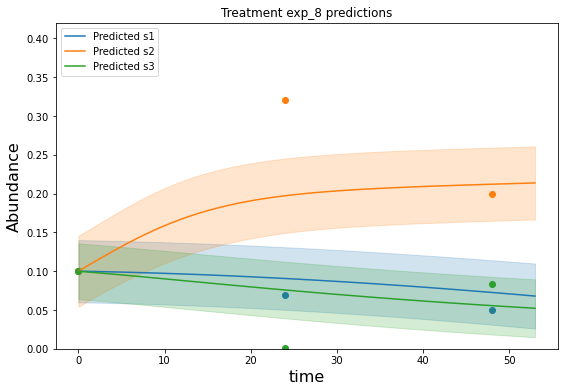

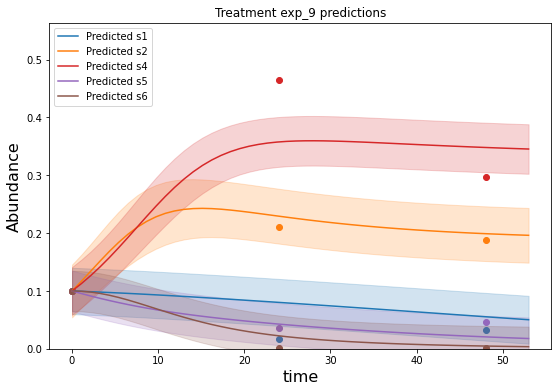

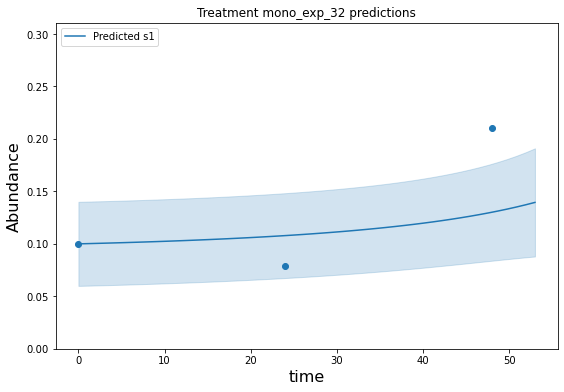

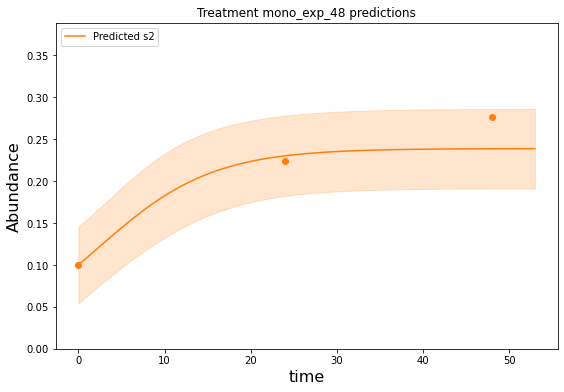

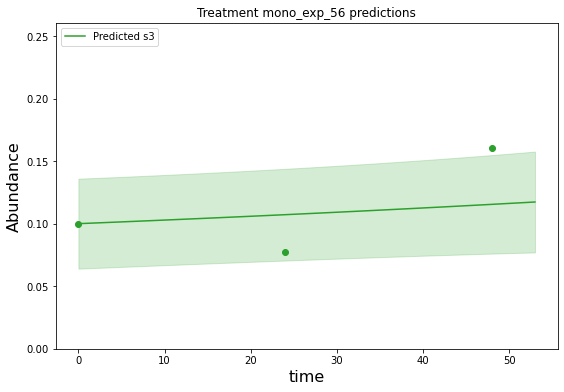

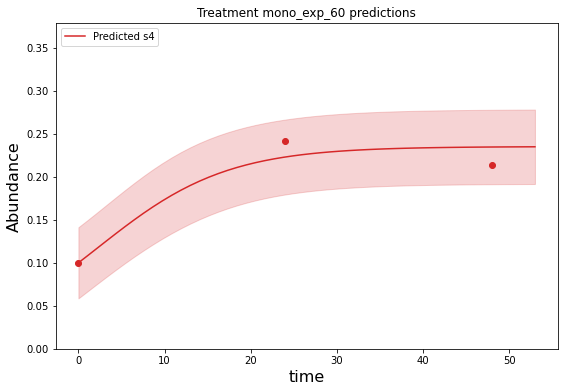

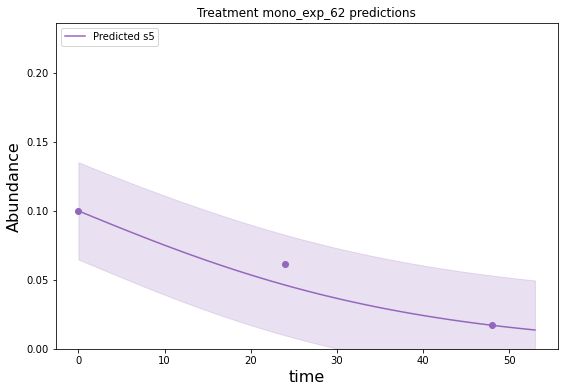

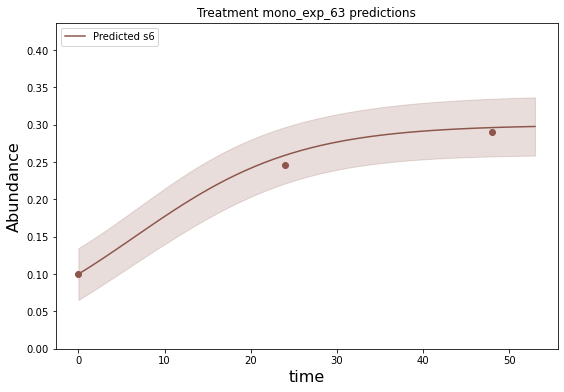

In [9]:
test_treatments, test_times, all_species_names, y_true, y_pred, y_std = test_model(model, full_data, species, plot=True)

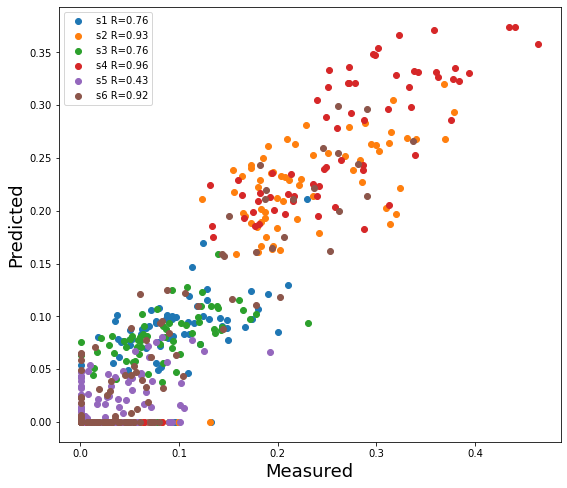

In [10]:
r_vals = []
plt.figure(figsize=(9,8))
for s in species:
    y_inds = np.in1d(all_species_names, s)
    y_s_true = np.array(y_true)[y_inds]
    y_s_pred = np.array(y_pred)[y_inds]
    
    r = linregress(y_s_true, y_s_pred).rvalue
    r_vals.append(r)
    plt.scatter(y_s_true, y_s_pred, label=s.replace("abs","")+" R={:.2f}".format(r))
plt.legend()
plt.xlabel("Measured", fontsize=18)
plt.ylabel("Predicted", fontsize=18)

plt.savefig("Results/gLV_fit_mf.pdf", dpi=200)
plt.show()

In [12]:
np.mean(r_vals)

0.7952059078240206